## Collection of terrible Graphs.
Graphs are plots of model based dyna implementation, without any annotations bedcause I am lazy.


In [6]:
import jax
import matplotlib.pyplot as plt

from base_rl.higher_order import make_train, CONFIG
from base_rl.models import ActorCritic
from dyna.training import make_dyna_train_fn 
from model_based.transition_models import EquiModel, Model
from model_based.nn_model import NNCartPole 
from model_based.sample_env import make_expert_experience_fn, make_experience_fn, SARSDTuple
import model_based.train as mbt
from dyna.types import ActorCriticHyperParams, DynaHyperParams, TransitionModelHyperParams 
import numpy as np
import jax.numpy as jnp
import matplotlib

matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif"})


# Train Expert  Transition Models:

In [7]:
rng = jax.random.PRNGKey(42)
expert = jax.jit(make_train(CONFIG, ActorCritic) )(rng)
ENV_NAME = "CartPole-v1"
EXP_TOTAL = 2e7
NUM_PARALLEL = 2000

train_state = expert["runner_state"][0]


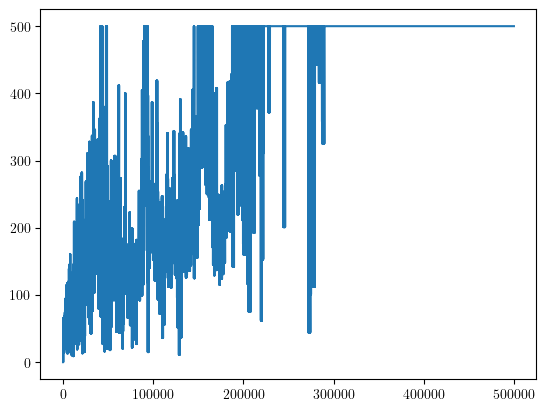

In [8]:
metrics = expert["metrics"]
returns = metrics[0]["returned_episode_returns"].reshape(-1)
plt.plot(returns)

In [9]:

expert_model_params = train_state.params
rng = jax.random.split(rng, NUM_PARALLEL)

random_experienc_fn = make_experience_fn(ENV_NAME, EXP_TOTAL // NUM_PARALLEL)
expert_experience_fn = make_expert_experience_fn(ENV_NAME, EXP_TOTAL//NUM_PARALLEL, expert_model_params)

random_experience = jax.vmap(random_experienc_fn)(rng)
expert_experience = jax.vmap(expert_experience_fn)(rng)

def flatten_shuff(rng, experience: SARSDTuple):
    _len= np.prod(experience.reward.shape)
    flat = jax.tree_map(lambda x: x.reshape(_len, -1), experience)
    perm = jax.random.permutation(rng, _len)
    shuff = jax.tree_map(lambda x: x.at[perm, ...].get(),flat)
    return shuff

rng = jax.random.PRNGKey(42)
expert_experience = flatten_shuff(rng, expert_experience)
random_experience = flatten_shuff(rng, random_experience)


/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [10]:
expert_experience = expert_experience.join(random_experience)
def make_model(hyp):
    train_data, val_data = expert_experience.partition(hyp.get_train_size(expert_experience))
    train_fn = mbt.make_train(hyp, train_data, val_data)
    return train_fn(rng)

hyp = mbt.HyperParams()
equi_hyp = mbt.HyperParams(model= EquiModel)


tm = make_model(hyp)
equi_tm = make_model(equi_hyp)


# Sense Check model converges.


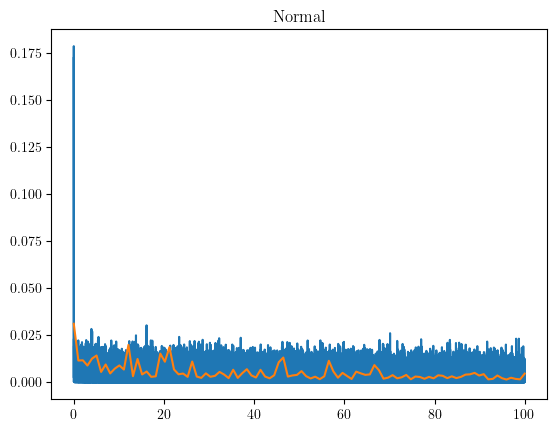

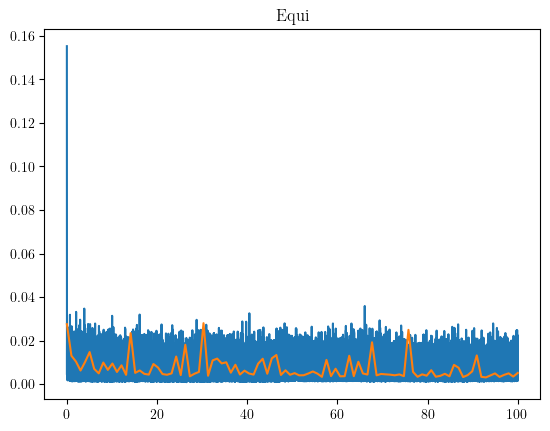

In [ ]:

def plot_tm(tm, tit):
    train_loss = tm[1][0].train_loss.reshape(-1)
    val_loss = tm[1][0].val_loss.reshape(-1)
    def get_x(line, epch):
        return jnp.linspace(0, epch, num = len(line))
    plt.plot(get_x(train_loss, 100), train_loss)
    plt.plot(get_x(val_loss, 100), val_loss)
    plt.title(tit)
plot_tm(tm, "Normal")
plt.show()
plot_tm(equi_tm, "Equi")

In [ ]:
NUM_UPDATES = 100 
TM_LR = 1e-4
AC_LR = 3.5e-4
NUM_SEEDS = 8
NUM_ENVS = 4
TM_EPOCHS = 20
PR = 1

ac_hyp = ActorCriticHyperParams(NUM_UPDATES=10, NUM_EPOCHS=1, LR=AC_LR, PRIV_NUM_TIMESTEPS=128)
eqi_hyp = TransitionModelHyperParams(MODEL_FN=EquiModel,LR=TM_LR, NUM_EPOCHS=0, PARAMS = equi_tm[0][1].params)
tm_hyp = TransitionModelHyperParams(MODEL_FN=Model,LR=TM_LR, NUM_EPOCHS=0, PARAMS=tm[0][1].params)
no_m_hyp = TransitionModelHyperParams(USE_MODEL=False, LR=TM_LR, NUM_EPOCHS=0, )
mf_hyp = DynaHyperParams(ac_hyp, no_m_hyp, NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS)
dyna_hyp = DynaHyperParams(ac_hyp, tm_hyp, NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS )
equi_hyp = DynaHyperParams(ac_hyp, eqi_hyp,NUM_UPDATES=NUM_UPDATES, PLANNING_RATIO=PR, NUM_ENVS=NUM_ENVS)

rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, NUM_SEEDS)
results= []
hyp = [mf_hyp, dyna_hyp, equi_hyp]
names = ['Model Free', 'Dyna', 'Equi-Dyna']
def stack_tuple_list(tup_list):
    items = [[] for _ in tup_list[0]]
    for tup in tup_list:
        for i, item in enumerate(tup):
            items[i].append(item)
    return tuple([jnp.stack(item) for item in items if item])

    
outer_results = {}
for pr in [1, 2, 4, 8]:
    results = []
    for h in hyp[:]:
        h = h._replace(PLANNING_RATIO=pr,)
        train_fn = jax.vmap(make_dyna_train_fn(h, NNCartPole))
        rng_split_fn = jax.vmap(jax.random.split)
        def scan_train(rng_state, _ ):
            res = train_fn(rng_state)
            rng_state = rng_split_fn(rng_state)[:, :, -1]
            _, res_info = res
            return rng_state, res_info[1]
        _, result = jax.lax.scan(
            scan_train,
            rngs,
            None,
            length=4
        )
        results.append(result)
        del scan_train
    outer_results[pr] = results
        

In [ ]:
import pickle
file = open("./dyna/expert.pkl", "wb")
pickle.dump(outer_results, file=file)


1 :
Dyna
66.125 +- 6.724452
240.125 +- 19.70479
500.0 +- 0.0
Equi-Dyna
66.125 +- 6.724452
135.21875 +- 10.1104965
482.3125 +- 14.888874
2 :
Dyna
66.125 +- 6.724452
335.4375 +- 22.989124
500.0 +- 0.0
Equi-Dyna
66.125 +- 6.724452
134.84375 +- 9.90631
476.21875 +- 15.989848
4 :
Dyna
66.125 +- 6.724452
388.6875 +- 22.861525
500.0 +- 0.0
Equi-Dyna
66.125 +- 6.724452
178.875 +- 12.3979225
442.09375 +- 21.0899
8 :
Dyna
66.125 +- 6.724452
461.21875 +- 16.272623
499.28125 +- 0.70743036
Equi-Dyna
66.125 +- 6.724452
224.34375 +- 20.69942
351.9375 +- 31.003084


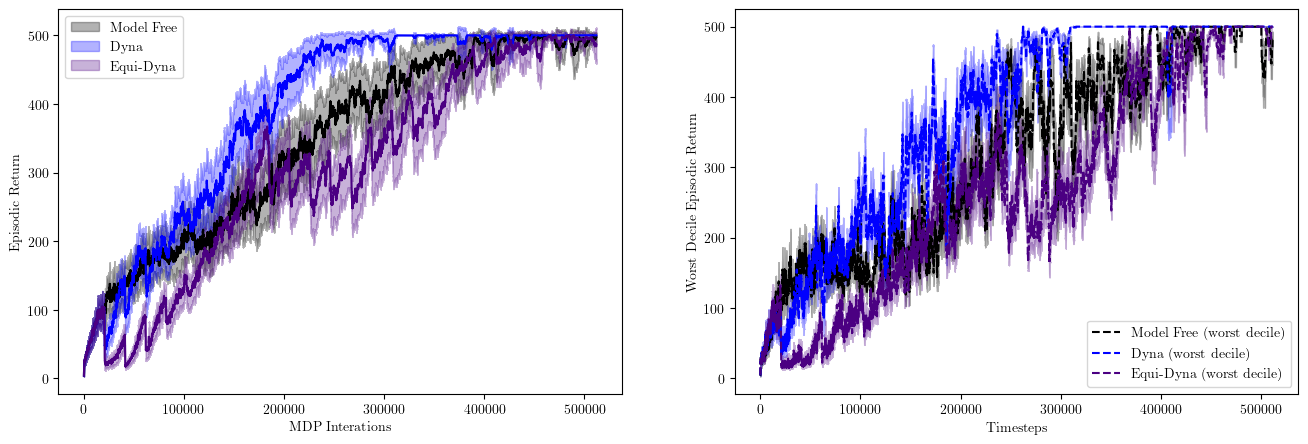

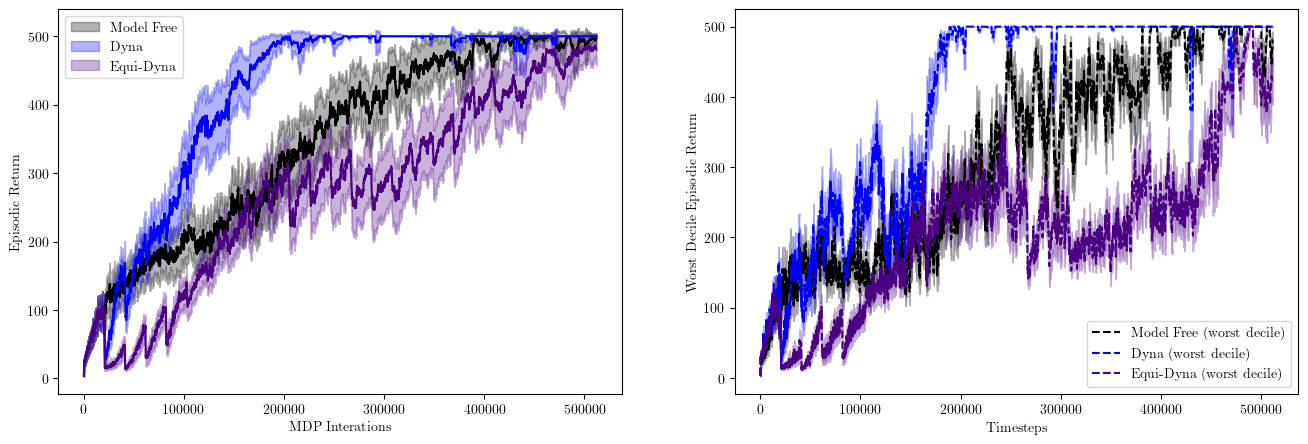

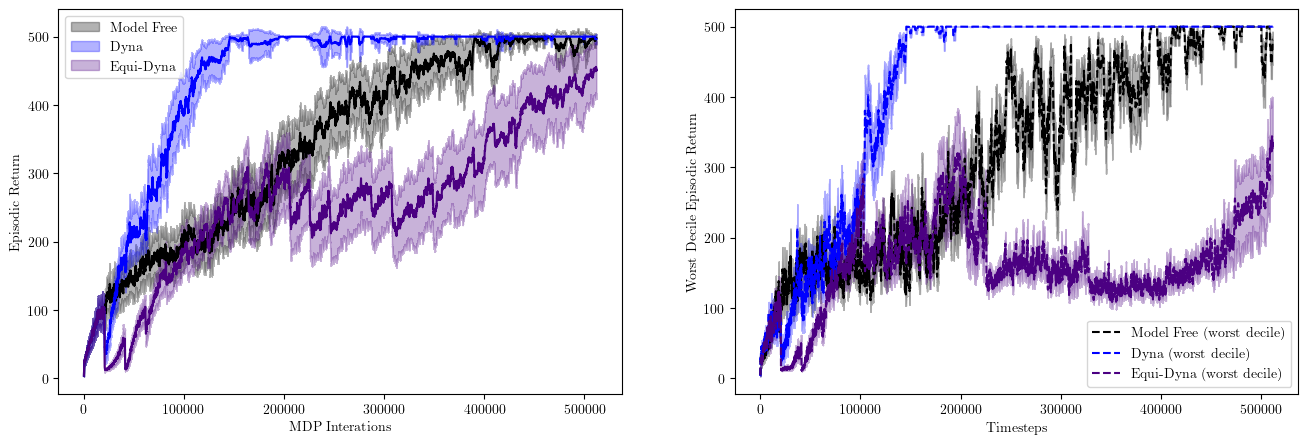

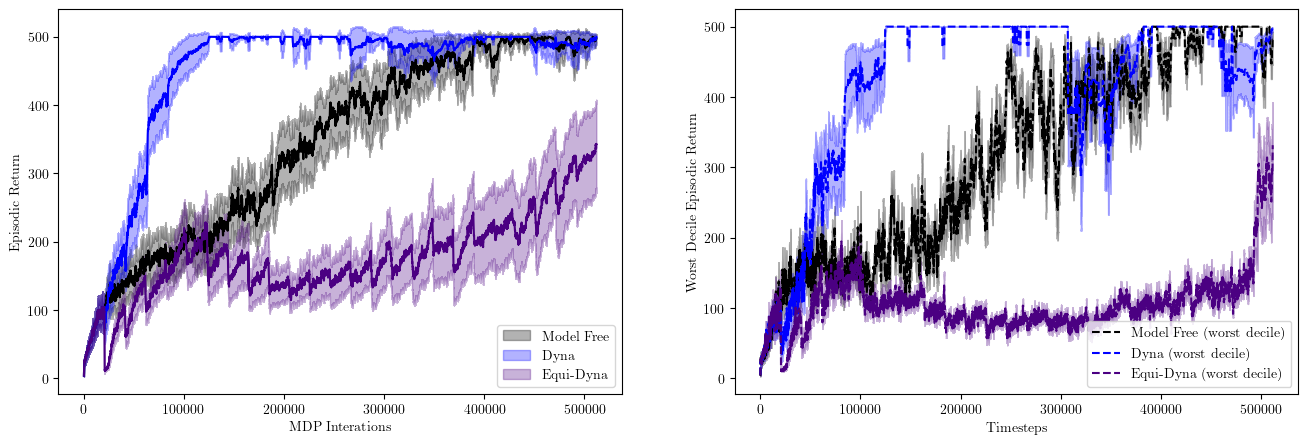

In [ ]:
num_seeds = NUM_SEEDS * 4
def moving_average(x, w=100):
    return np.convolve(x, np.ones(w), "valid") / w
for pr, results in outer_results.items():
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    cs = ["black", "blue", "indigo"]
    print(pr, ":")
    
    for res, name, c in zip(results, names, cs):
        # traj = res[1]
        traj = res
        # acting_returns = 1 - traj.info["returned_episode_returns"]/ 500
        # ax[0].set_ylim(1e-2, 1)
        # ax[1].set_ylim(1e-2, 1)
        acting_returns = traj.info["returned_episode_returns"]
        acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
        acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
        acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
        acting_returns_mean = moving_average(acting_returns_mean)
        acting_returns_std = moving_average(acting_returns_std)
        lower = acting_returns_mean - acting_returns_std
        upper = acting_returns_mean + acting_returns_std
        x = jnp.arange(len(acting_returns_mean))
        ax[0].plot(acting_returns_mean, color=c)
        ax[0].fill_between(jnp.arange(len(acting_returns_mean)), lower, upper, alpha=0.3,  label=name, color=c, )
        ax[0].legend()    
        ax[0].set_xlabel("MDP Interations")
        ax[0].set_ylabel("Episodic Return")
        cumulative_returns = np.cumsum(acting_returns, axis=1)[:, -1]
        worst_decile = np.quantile(cumulative_returns, 0.1)
        worst_mean = acting_returns[cumulative_returns < worst_decile].mean(axis=0)
        worst_std = acting_returns[cumulative_returns < worst_decile].std(
            axis=0
        ) / np.sqrt(NUM_SEEDS)
        worst_upper = worst_mean + worst_std
        worst_lower = worst_mean - worst_std
        ax[1].plot(
            x,
            moving_average(worst_mean),
            label=f"{name} (worst decile)",
            linestyle="--",
            color=c,
        )
        ax[1].fill_between(
            x,
            moving_average(worst_lower),
            moving_average(worst_upper),
            alpha=0.3,
            color=c,
        )
        ax[1].set_xlabel("Timesteps")
        ax[1].set_ylabel("Worst Decile Episodic Return")
        if name != "Model Free":
            print(name)
            print(acting_returns.mean(axis=0)[10_000],"+-", acting_returns.std(axis=0)[10_000]/np.sqrt(num_seeds))
            print(acting_returns.mean(axis=0)[100_000],"+-", acting_returns.std(axis=0)[100_000]/np.sqrt(num_seeds))
            print(acting_returns.mean(axis=0)[-1],"+-", acting_returns.std(axis=0)[-1]/np.sqrt(num_seeds))


    ax[0].legend()
    ax[1].legend()
    fig.savefig("plots.png")




Text(0.5, 0.01, 'Planning Ratio')

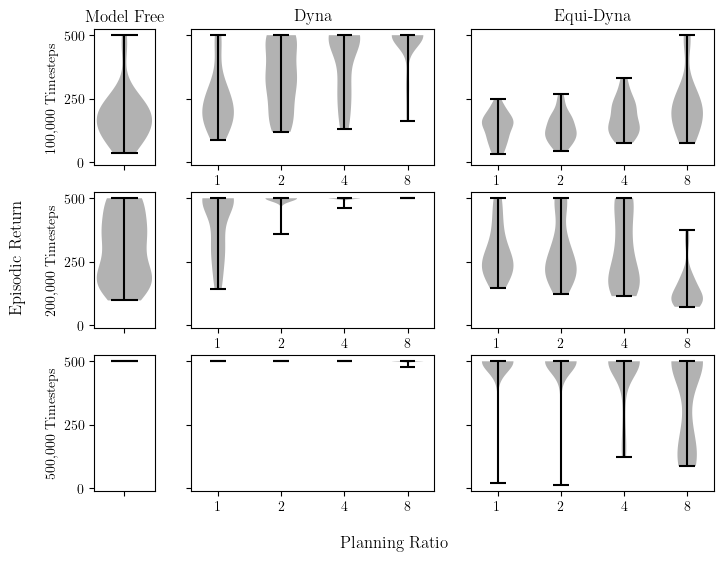

In [ ]:
for pr, results in outer_results.items():
    for res, name, c in zip(results, names, cs):
        # traj = res[1]
        traj = res
        # acting_returns = 1 - traj.info["returned_episode_returns"]/ 500
        # ax[0].set_ylim(1e-2, 1)
        # ax[1].set_ylim(1e-2, 1)
        acting_returns = traj.info["returned_episode_returns"]
        acting_returns = acting_returns.reshape(np.prod(acting_returns.shape[:2]), -1)
        acting_returns_mean = jnp.mean(acting_returns, axis=0).reshape(-1)
        acting_returns_std = jnp.std(acting_returns, axis=0).reshape(-1)/ np.sqrt(NUM_SEEDS)
        acting_returns_mean = moving_average(acting_returns_mean)
        acting_returns_std = moving_average(acting_returns_std)
        lower = acting_returns_mean - acting_returns_std
        upper = acting_returns_mean + acting_returns_std
        x = jnp.arange(len(acting_returns_mean))
        first = acting_returns[:, 100_000]
        second = acting_returns[:, 200_000]
        last = acting_returns[:, -1]
        results_dict["first"][(name, pr)] = first
        results_dict["second"][(name, pr)] = second
        results_dict["last"][(name, pr)] = last
        
fig, ax = plt.subplots(3,3, figsize=(8, 6), sharey=True, width_ratios=[1, 4, 4])
mappings = {"first": "100,000", "second": "200,000", "last": "500,000"}
for i, step in enumerate(results_dict):
    values = {name : [results_dict[step][(name, pr)] for pr in outer_results] for name in names}
    for j, (name, c) in enumerate(zip(names, cs)):
        if name == "Model Free":
            vp = ax[i, j].violinplot(values[name][0], widths=[0.2])
            ax[i,j].set_xticks([1], [None])
        else: 
            vp =ax[i, j].violinplot(values[name], )
            ax[i, j].set_xticks([1, 2,3, 4], [1, 2, 4, 8])
            ax[i, j].set_yticks([0,250, 500],)
        ax[0, j].set_title(name)
        for part in vp["bodies"]:
            part.set_facecolor("black")
        for partname in ('cbars','cmins','cmaxes',):
            vp[partname].set_color("black")


    ax[i, 0].set_ylabel(mappings[step] + " Timesteps")
fig.supylabel("Episodic Return")
fig.supxlabel("Planning Ratio")
# fig.tight_layout()
        
    

In [ ]:
for info, name in zip(results[1:], names[1:]):
    m_loss= info[-1]
    plt.plot(m_loss.mean(axis=(0, 1)).reshape(-1),  label=name)
    print(jnp.min(m_loss.mean(axis=(0, 1)).reshape(-1)))
    
plt.legend()

AttributeError: 'dict' object has no attribute 'mean'